In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Load your dataset
df = pd.read_csv("FinalDataset.csv")

# Split features and target
X = df.drop(columns=['Price'])
y = df['Price']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Identify numerical vs. OHE (0/1)
ohe_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
num_cols = [col for col in X.columns if col not in ohe_cols]

# Standardize numerical features
scaler_X = StandardScaler()
X_train[num_cols] = scaler_X.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler_X.transform(X_val[num_cols])
X_test[num_cols] = scaler_X.transform(X_test[num_cols])

# Standardize target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()

# GridSearchCV
param_grid = {
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train_scaled)

# Best estimator
best_svr = grid_search.best_estimator_

# Predict on validation
val_preds_scaled = best_svr.predict(X_val)
val_preds = scaler_y.inverse_transform(val_preds_scaled.reshape(-1, 1)).ravel()

# Evaluation
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

# Adjusted R²
n_val = X_val.shape[0]
p_val = X_val.shape[1]
val_adj_r2 = 1 - (1 - val_r2) * (n_val - 1) / (n_val - p_val - 1)

print("Best Parameters:", grid_search.best_params_)
print("Validation RMSE:", val_rmse)
print("Validation R² Score:", val_r2)
print("Validation Adjusted R² Score:", val_adj_r2)


Best Parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'auto'}
Validation RMSE: 5114.894463510426
Validation R² Score: 0.8843793624309019
Validation Adjusted R² Score: 0.8822249406128442


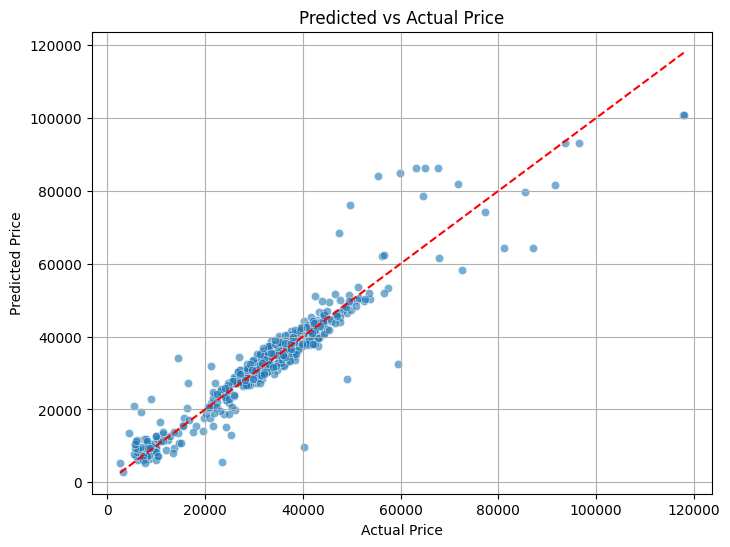

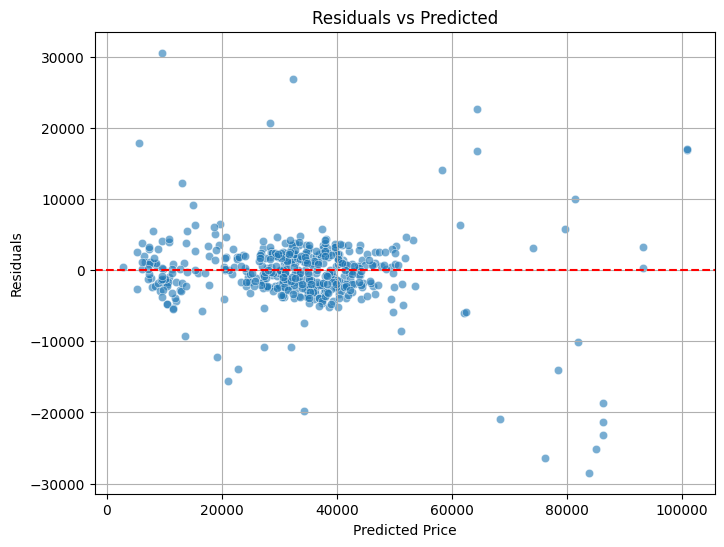

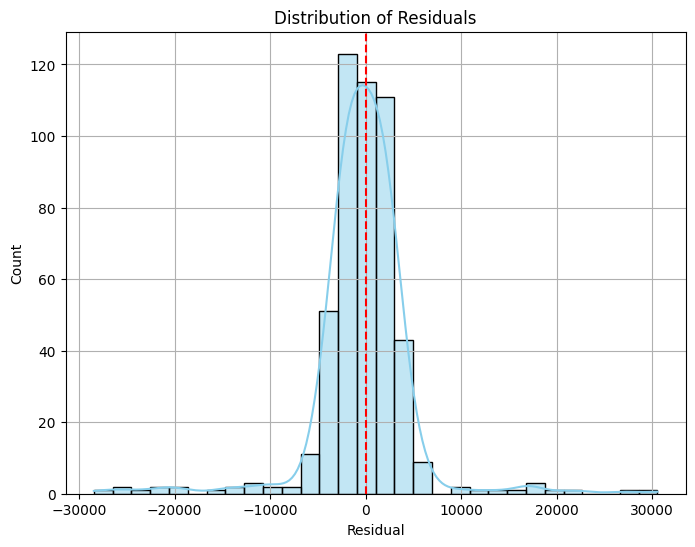

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Predicted vs Actual ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=val_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price")
plt.grid(True)
plt.show()

# --- 2. Residual Plot ---
residuals = y_val - val_preds

plt.figure(figsize=(8, 6))
sns.scatterplot(x=val_preds, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

# --- 3. Histogram of Residuals ---
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()


In [7]:
# Predict on the test set
test_preds_scaled = best_svr.predict(X_test)
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).ravel()

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)

print("Test RMSE:", test_rmse)
print("Test R² Score:", test_r2)

# Number of test samples and predictors
n = X_test.shape[0]
p = X_test.shape[1]

# Adjusted R² calculation
test_adj_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)

print("Adjusted R² Score:", test_adj_r2)


Test RMSE: 12063.521329881183
Test R² Score: 0.6669785024711907
Adjusted R² Score: 0.6607859539634235


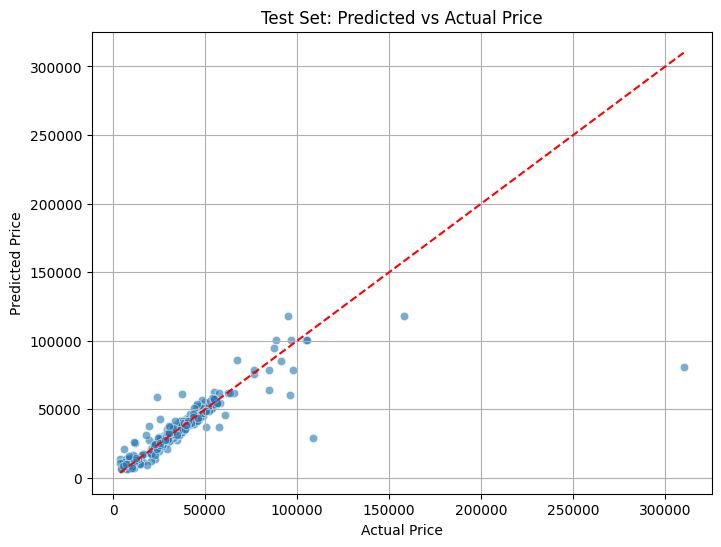

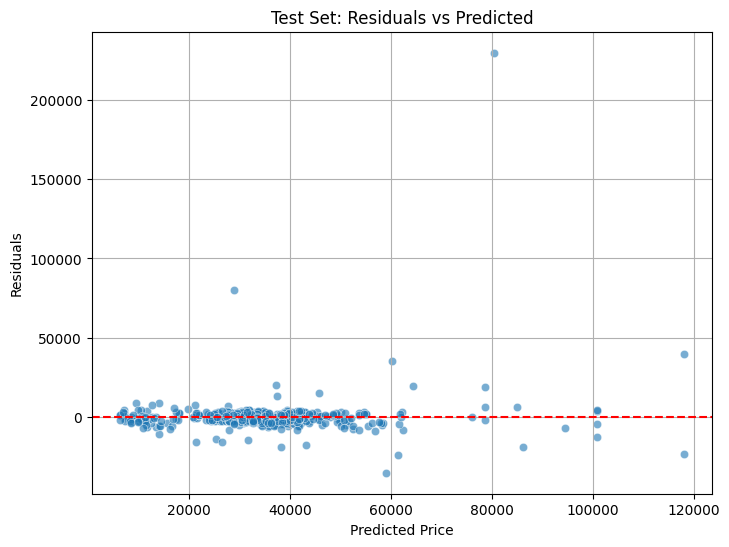

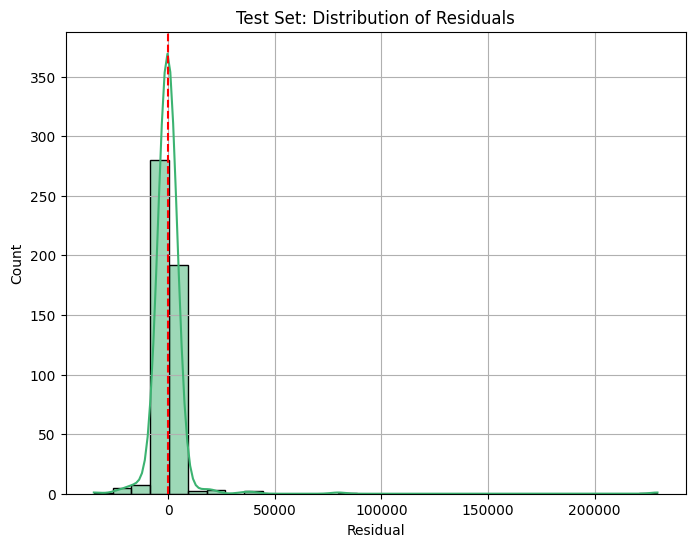

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Actual vs Predicted (Test Set) ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=test_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Test Set: Predicted vs Actual Price")
plt.grid(True)
plt.show()

# --- 2. Residual Plot ---
test_residuals = y_test - test_preds

plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_preds, y=test_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Test Set: Residuals vs Predicted")
plt.grid(True)
plt.show()

# --- 3. Histogram of Residuals ---
plt.figure(figsize=(8, 6))
sns.histplot(test_residuals, kde=True, bins=30, color='mediumseagreen')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual")
plt.title("Test Set: Distribution of Residuals")
plt.grid(True)
plt.show()
